*now defunct notebook. IDL code to generate NSA+GALEX+2MASS catalog with K-correct absolute magnitudes*
## Amalgamate NSA, GALEX, and 2MASS data 
In order to answer some of the referee reports, I need to combine data from different sources!

In [1]:
import numpy as np
import h5py
from pydl.pydlutils.spheregroup import spherematch

import matplotlib.pyplot as plt
%matplotlib inline 

from ChangTools.fitstables import mrdfits
from ChangTools.plotting import prettyplot
from ChangTools.plotting import prettycolors

/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
prettyplot()
pretty_colors = prettycolors()

In [3]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [4]:
import os

if os.path.isdir('/Volumes/750GB/hahn/cenque/observations/'): 
    local_dir = '/Volumes/750GB/hahn/cenque/observations/'
elif os.path.isdir('/Volumes/ChangHDD/project/cenque/observations/'): 
    local_dir = '/Volumes/ChangHDD/project/cenque/observations/'
print local_dir

/Volumes/750GB/hahn/cenque/observations/


## Import v_0_1_2 NSA
import the latest version of NSA data. Data description here: http://www.nsatlas.org/data . Contains FNugriz magnitudes. 

In [5]:
nsa_data = mrdfits(local_dir+'nsa_v0_1_2.fits')
print len(nsa_data.ra), 'galaxies'

145155 galaxies


In [6]:
print sorted(list(nsa_data.__dict__.keys()))

['absmag', 'ahdew', 'ahdewerr', 'ahgew', 'ahgewerr', 'aid', 'amivar', 'asymmetry', 'av', 'b1000', 'b300', 'ba50', 'ba90', 'bastokes', 'camcol', 'clumpy', 'coeff', 'd4000', 'd4000err', 'dec', 'deccat', 'dflags', 'dversion', 'extinction', 'fa', 'faerr', 'fiberflux', 'fiberflux_ivar', 'fiberid', 'field', 'haew', 'haewerr', 'haflux', 'hafluxerr', 'havmeas', 'havmerr', 'hbew', 'hbewerr', 'hbflux', 'hbfluxerr', 'hbvmeas', 'hbvmerr', 'ialfalfa', 'iauname', 'ined', 'isdss', 'isixdf', 'itwodf', 'izcat', 'kcoeff', 'kcorrect', 'mag', 'mass', 'mets', 'mjd', 'mtol', 'n2ew', 'n2ewerr', 'n2flux', 'n2fluxerr', 'n2vmeas', 'n2vmerr', 'ne3ew', 'ne3ewerr', 'ne5ew', 'ne5ewerr', 'nmgy', 'nmgy_ivar', 'nprof', 'nsaid', 'o1ew', 'o1ewerr', 'o1flux', 'o1fluxerr', 'o1vmeas', 'o1vmerr', 'o2ew', 'o2ewerr', 'o2flux', 'o2fluxerr', 'o2vmeas', 'o2vmerr', 'o3ew', 'o3ewerr', 'o3flux', 'o3fluxerr', 'o3vmeas', 'o3vmerr', 'objno', 'ok', 'petroflux', 'petroflux_ivar', 'petroth50', 'petroth90', 'petrotheta', 'phi50', 'phi90',

## VAGC k-correct data
This contains data from ugrizJHK magnitudes from $\bf model$ or $\bf petro$ fluxes (http://cosmo.nyu.edu/blanton/vagc/kcorrect.html). Note that the data is kcorrect-ed to $z = 0.0$ and $\bf NO$ fiber collision correct. The cosmology used is the same as NSA ($\Omega_m = 0.3$, $\Omega_\Lambda = 0.7, h = 1$)

Note that both kcorrect with model flux and kcorrect with petro flux have the same extinction corrected AB fluxes for 2MASS. 

In [8]:
#kcorr_data = mrdfits(local_dir+'kcorrect.none.model.z0.00.fits') # VAGC kcorrect with model fluxes
kcorr_data = mrdfits(local_dir+'kcorrect.none.petro.z0.00.fits') # VAGC kcorrect with petro fluxes
print len(kcorr_data.ra), 'galaxies'

2506754 galaxies


In [9]:
print sorted(kcorr_data.__dict__.keys())

['abmaggies', 'abmaggies_ivar', 'absmag', 'absmag_ivar', 'b1000', 'b300', 'coeffs', 'dec', 'intsfh', 'kcorrect', 'mass', 'mets', 'mtol', 'ra', 'z']


### Match VAGC to NSA

In [10]:
m_nsa_kcorr, m_kcorr_nsa, dd = spherematch(nsa_data.ra, nsa_data.dec, kcorr_data.ra, kcorr_data.dec, 0.001)

In [11]:
print len(m_nsa_kcorr), 'matches'

126549 matches


## Sanity-checks on the matches
Check a number of data columns with each other to make sure that they are the same galaxies!

In [10]:
assert np.abs(nsa_data.ra[m_nsa_kcorr] - kcorr_data.ra[m_kcorr_nsa]).min() < 0.001
assert np.abs(nsa_data.dec[m_nsa_kcorr] - kcorr_data.dec[m_kcorr_nsa]).min() < 0.001

Because NSA uses DR8 photometry while VAGC uses DR7 photometry, there will be differences in all the values. Furthermore, NSA K-corrects using GALEX + Sersic fluxes from SDSS DR8, while VAGC corrects using Petrosian/Model fluxes from SDSS DR7 and 2MASS. So, I think, the correct thing to do here would be to assemble AB fluxes of [GALEX, SDSS DR8 Sersic ugriz, 2MASS], run K-correct to z = 0. 

[  26.09586906   71.77107239  100.26631927  127.58375549  130.22434998]
[  29.55904961   72.09842682  101.23332214  122.08704376  134.84332275]
[ 0.15295593  0.1284142   0.04631269  0.03510745  0.02046486]
[ 0.11207695  0.08627526  0.04970221  0.0223344   0.01950765]
[  2.19396884e-06   3.37851430e-22   3.93401210e-17   3.69336449e-05
   2.22649090e-15]
[  3.87625323e-06   3.43058415e-10   4.85246346e-07   2.03782274e-05
   3.29407357e-07]


(0.0, 500.0)

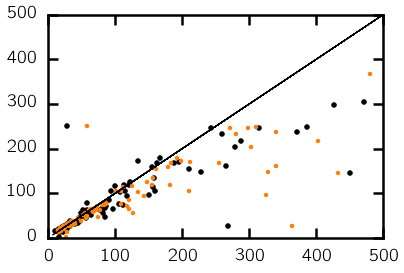

In [43]:
# compare the AB maggies for the shared u, g, r, i, z bands
fig = plt.figure()
#for i_b, band in enumerate(['u', 'g', 'r', 'i', 'z']): 
#    sub = fig.add_subplot(1,5,i_b+1)
sub = fig.add_subplot(111)
i_b = 0 
print (nsa_data.petroflux[m_nsa_kcorr, :][1] * 10**(0.4 * nsa_data.extinction[m_nsa_kcorr][0]))[2:]
print (kcorr_data.abmaggies[m_kcorr_nsa, :][1] * 1e9)[:5]
print (nsa_data.kcorrect[m_nsa_kcorr,2:])[0]
print (kcorr_data.kcorrect[m_kcorr_nsa,:5])[0]
print (nsa_data.kcoeff[m_nsa_kcorr])[0]
print (kcorr_data.coeffs[m_kcorr_nsa])[0]

sub.scatter(nsa_data.nmgy[m_nsa_kcorr, 2+i_b][:100], kcorr_data.abmaggies[m_kcorr_nsa,i_b][:100]*1e9, c='k')
f_extinct = 10**(0.4 * nsa_data.extinction[m_nsa_kcorr])
sub.scatter(nsa_data.petroflux[m_nsa_kcorr, 2+i_b][:100] * f_extinct[:100, 2+i_b] , kcorr_data.abmaggies[m_kcorr_nsa,i_b][:100]*1e9, 
            c=pretty_colors[3], lw=0)
sub.plot(nsa_data.petroflux[m_nsa_kcorr, 2+i_b][:100], nsa_data.petroflux[m_nsa_kcorr, 2+i_b][:100], c='k', ls='--')
sub.set_xlim([0., 5e2])
sub.set_ylim([0., 5e2])

### Combined data dictionary

In [ ]:
# first dump all NSA data 
nsa = {} 
for key in nsa_data.__dict__.keys(): 
    nsa[key] = getattr(nsa_data, key)

In [ ]:
# supplement NSA absolute magnitude values
nsa['vagc_id'] = np.repeat(-999., len(nsa['ra']))
nsa['vagc_id'][m_nsa_kcorr] = m_kcorr_nsa
for i_band, band in enumerate(['u', 'g', 'r', 'i', 'z', 'j', 'h', 'k']): 
    nsa['vagc_absmag_'+band] = np.repeat(-999., len(nsa['ra']))
    nsa['vagc_absmag_'+band][m_nsa_kcorr] = kcorr_data.absmag[:,i_band][m_kcorr_nsa]

In [ ]:
print nsa['vagc_absmag_r'][:10]

### Supplement NSA with $SFR_{UV}$ from GALEX 
These functions are from Nitya's code

In [ ]:
def jansky(flux, kcorrect):
    '''Getting fluxes in Janskies from Nanomaggies:
    Inputs: Choose Petrosian/Sersic Nmgy and the relevant Kcorrection
    '''
    flux_in_Jy = flux*3631*(10.0**(-9.0))*(10**(kcorrect/(-2.5)))
    return flux_in_Jy

In [ ]:
def jansky_err(flux,kcorrect):
    '''Inverse Variance in Fluxes: (Input Flux inverse variance in Nmgy^-2)
    '''
    Jy_err = (flux**(-0.5))*3631*(10.0**(-9.0))*(10**(kcorrect/(-2.5)))
    return Jy_err

In [ ]:
def UVsfr(z,fmag,nmag,rmag,f_flux):
    ''' Calculate UV star formation rates. 
    Inputs: NSAID,z,F-band magnitude, N-band magnitude, r-band magnitude, F-band flux in Janskies
    '''
    fn = fmag - nmag
    opt = nmag - rmag   # N-r
    
    #Luminosity Distance
    dist = cosmo.comoving_distance(z)
    ldist = (1+z)*dist
    
    #calculating Attenuation 'atten'
    atten = np.repeat(-999., len(fmag)) 

    case1 = np.where((opt > 4.) & (fn < 0.95)) 
    atten[case1] = 3.32*fn[case1] + 0.22
    case2 = np.where((opt > 4.) & (fn >= 0.95))
    atten[case2] = 3.37
    case3 = np.where((opt <= 4.) & (fn < 0.9))
    atten[case3] = 2.99*fn[case3] + 0.27
    case4 = np.where((opt <= 4.) & (fn >= 0.9))
    atten[case4] = 2.96

    #if opt >= 4.0:
    #    if fn < 0.95:
    #        atten = 3.32*fn + 0.22
    #    else:
    #        atten = 3.37
    #else:
    #    if fn < 0.90:
    #        atten = 2.99*fn +0.27
    #    else:
    #        atten = 2.96

    lum = 4.*np.pi*(ldist**2.0)*(3.087**2.0)*(10**(25.0 +(atten/2.5)))*f_flux  #Luminosity
    sfr = 1.08*(10**(-28.0))*np.abs(lum)
    return sfr

In [ ]:
def NSA_SFR_UV(nsa_data, flux_choice): 
    ''' Given NSA data dictionary calculate the UV sfrs 
    '''
    if flux_choice not in ['elpetro', 'sersic']: 
        raise ValueError
        
    if flux_choice == 'elpetro': 
        flux_tag = 'petroflux'
    elif flux_choice == 'sersic': 
        flux_tag = 'sersicflux'

    fuv_nanomags = nsa_data[flux_tag][:,0]
    not_nans = (fuv_nanomags > 0.) 
    print len(fuv_nanomags) - np.sum(not_nans), " galaxies don't have UV"

    fuv_jansky = np.repeat(-999., len(fuv_nanomags))
    fuv_jansky[np.where(not_nans)] = jansky(fuv_nanomags[np.where(not_nans)], 0.) 

    absmags = nsa_data['absmag']
    f_notnans = (absmags[:,0] != -9999.)
    n_notnans = (absmags[:,1] != -9999.)
    r_notnans = (absmags[:,4] != -9999.)
    
    has_everything = np.where(not_nans & f_notnans & n_notnans & r_notnans)
    uvsfrs = np.repeat(-999., len(fuv_nanomags))
    uvsfrs[has_everything] = UVsfr(
            nsa_data['z'][has_everything], 
            absmags[:,0][has_everything], 
            absmags[:,1][has_everything], 
            absmags[:,4][has_everything], 
            fuv_jansky[has_everything])

    return uvsfrs 

### Add $SFR_{UV}$ values to NSA dictionary

In [ ]:
nsa['sfr_uv_elpetro'] = NSA_SFR_UV(nsa, 'elpetro')
nsa['sfr_uv_sersic'] = NSA_SFR_UV(nsa, 'sersic')

In [ ]:
fig = plt.figure(figsize=(8,8))
sub = fig.add_subplot(111)

sub.scatter(np.log10(nsa['sfr_uv_elpetro']), np.log10(nsa['sfr_uv_sersic']), c=pretty_colors[3], lw=0)
sub.plot([-5.,3.], [-5.,3.], c='k', ls='--', lw=3)

sub.set_xlabel('$\mathtt{SFR_{UV}}$ Petrosian')
sub.set_xlim([-5., 3.])
sub.set_xlabel('$\mathtt{SFR_{UV}}$ Sersic')
sub.set_ylim([-5., 3.])

# Save NSA dictionary to hdf5 file 

In [ ]:
import pickle

In [ ]:
nsa_dict_file = ''.join([local_dir, 'NSA_2MASS_UVSFR.p'])

In [ ]:
pickle.dump(nsa, open(nsa_dict_file, 'wb'))